# Land impact 

Deforestation due to commodity-driven agriculture can be direct or indirect. Direct impact would be land use change in order to create new arable land (i.e. cutting trees for pasture, or cropland) whereas indirect would be deforestation to create new roads to accommodate better supply and transport, to build villages to house a workforce etc. Here we will only consider direct deforestation but we will be exploring the indirect impacts associated with land expansion.

First we define the land impact as the area from where a commodity is more likely to be purchased. In this case the  is equal to the harvest area for the commodity of interest:

    Land impact (ha)  = (Harvested area (ha) / Production (t)) * (Harvested area (ha) / Total Harvested area (ha)) * Volume (t)
    
    Land impact (ha)  = (1/Yield (t ha⁻¹)) * (Harvested area (ha) / Total Harvested area (ha)) * Volume (t)

# Table of Contents
- # [Setup](#setup)
    - ## [Library import](#import)
    - ## [Utils](#utils)
- # [Data import](#data)
    - ## [Vector data ](#vector)
        - ### [Indonesia](#indonesia)
    - ## [Raster data](#raster)
        - #### [Palm oil harvested area](#harvested)
        - #### [Palm oil production](#production)
- # [Compute land impact](#impact)
- # [Deforestation loss due to land use change](#deforestation)
    - ### [Tree cover loss](#loss)
- # [Carbon emissions due to land use change](#carbon)
    - ### [Forest greenhouse gas net flux](#flux)
- # [Biodiversity loss due to land use change](#biodiversity)
    - ### [Regional Potential Species Loss](#species)


<a id='setup'></a>
# Setup

<a id='import'></a>
## Library import

In [2]:
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import rasterio as rio
from osgeo import gdal
import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import matplotlib as mpl
import shapely.wkb 
import requests

<a id='utils'></a>
## Utils

**da_plot**

In [3]:
def da_plot(da, gdf, color_list, values, title, x='x', y='y', xlim=(65,100), ylim=(4,40)):
    # Define the colors you want
    cmap = ListedColormap(color_list)

    # Define a normalization from values -> colors
    norm = colors.BoundaryNorm(values, len(color_list))

    plt.figure(figsize=(12,10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_global()

    gdf.plot(ax=ax, color='k', alpha=0.1, edgecolor='k')
    da.plot(ax=ax, norm=norm, cmap=cmap, x=x, y=y, transform=ccrs.PlateCarree())
    #gdf.plot(ax=ax, color='w', alpha=0.1, edgecolor='k')
    ax.coastlines()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_title(title)

**upsample_raster**

In [4]:
def upsample_raster(referenceFile, inputFile, outputFile):
    # Open reference file and get resolution
    reference = gdal.Open(referenceFile, 0)  # this opens the file in only reading mode
    referenceTrans = reference.GetGeoTransform()
    x_res = referenceTrans[1]
    y_res = -referenceTrans[5]  # make sure this value is positive

    # call gdal Warp
    kwargs = {"format": "GTiff", "xRes": x_res, "yRes": y_res, "resampleAlg": "average", "outputType": gdal.gdalconst.GDT_Float32}
    ds = gdal.Warp(outputFile, inputFile, **kwargs)
    del ds

<a id='data'></a>
# Data import

<a id='vector'></a>
## Vector data 

<a id='indonesia'></a>
### Indonesia (Aceh)

In [5]:
#import geometry:
geom = gpd.read_file('../../datasets/raw/land/QA/gadm36_IDN/gadm36_IDN_1.shp')
geom = geom.iloc[:1]
bounds = geom.geometry.bounds.iloc[0]
geom.head()

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1..."


<a id='raster'></a>
## Raster data

<a id='harvested'></a>
#### Palm oil harvested area

In [6]:
xda = rxr.open_rasterio('../../datasets/raw/spam2010v2r0_global_harv_area/spam2010V2r0_global_H_OILP_A.tif').squeeze().drop("band")

# Remove negative values
xda = xda.where(xda > 0)

# Convert to Dataset 
xds = xr.Dataset({'harvested_area': xda}, attrs=xda.attrs)
xds

<xarray.Dataset>
Dimensions:         (x: 4320, y: 2160)
Coordinates:
  * x               (x) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y               (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref     int64 0
Data variables:
    harvested_area  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

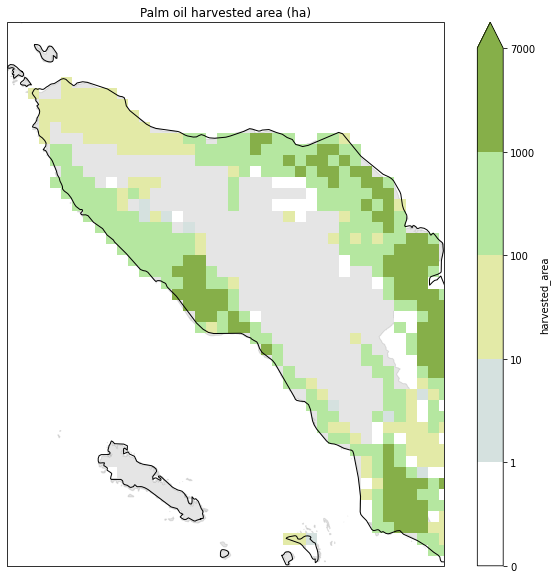

In [7]:
color_list = ["#ffffff", "#d5e1df", "#e3eaa7", "#b5e7a0", "#86af49"]
values = [0, 1, 10, 100, 1000, 7000]
title = 'Palm oil harvested area (ha)'

da_plot(xds['harvested_area'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

<a id='production'></a>
#### Palm oil production

In [8]:
xda = rxr.open_rasterio('../../datasets/raw/spam2010v2r0_global_prod/spam2010V2r0_global_P_OILP_A.tif').squeeze().drop("band")

# Remove negative values
xda = xda.where(xda > 0)

# Convert to Dataset 
xds = xds.assign(production = xda)
xds

<xarray.Dataset>
Dimensions:         (x: 4320, y: 2160)
Coordinates:
  * x               (x) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
  * y               (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref     int64 0
Data variables:
    harvested_area  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    production      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

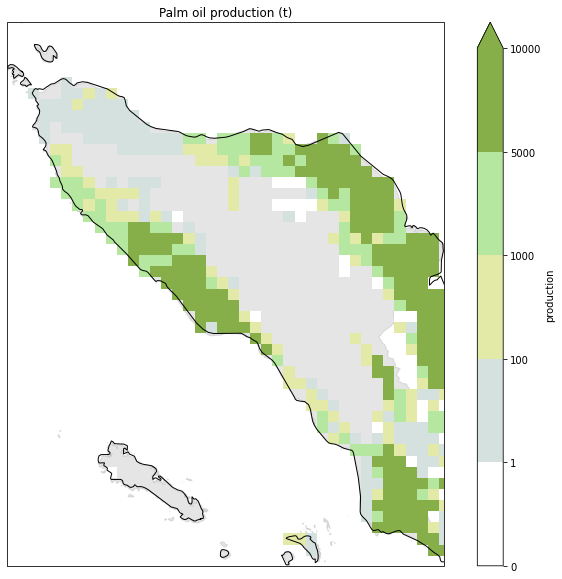

In [9]:
color_list = ["#ffffff", "#d5e1df", "#e3eaa7", "#b5e7a0", "#86af49"]
values = [0, 1, 100, 1000, 5000, 10000]
title = 'Palm oil production (t)'

da_plot(xds['production'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Total production of cotton**

In [10]:
tot_pro = xds['production'].sum().data
print(f'Total production of palm oil: {tot_pro} tonnes')

Total production of palm oil: 229629472.0 tonnes


<a id='impact'></a>
# Compute land impact

Land impact (ha)  = (Harvested area (ha) / Production (t)) * (Harvested area (ha) / Total Harvested area (ha)) * Volume (t)

We will assume that 1000 t are going to be purchased.

In [11]:
volume = 1000


**Clip datasets with Indonesia**

In [12]:
xds_idn = xds.rio.clip(geom.geometry, geom.crs, drop=False, invert=False)
xds_idn['production'] = xds_idn['production'].where(xds_idn['production'] > 0)
xds_idn['harvested_area'] = xds_idn['harvested_area'].where(xds_idn['harvested_area'] > 0)
xds_idn = xds_idn.sel(x=slice(bounds[0],bounds[2]), y=slice(bounds[3],bounds[1]))
xds_idn

<xarray.Dataset>
Dimensions:         (y: 49, x: 39)
Coordinates:
  * y               (y) float64 6.042 5.959 5.875 5.792 ... 2.209 2.125 2.042
  * x               (x) float64 95.04 95.12 95.21 95.29 ... 98.04 98.12 98.21
    spatial_ref     int64 0
Data variables:
    harvested_area  (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
    production      (y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

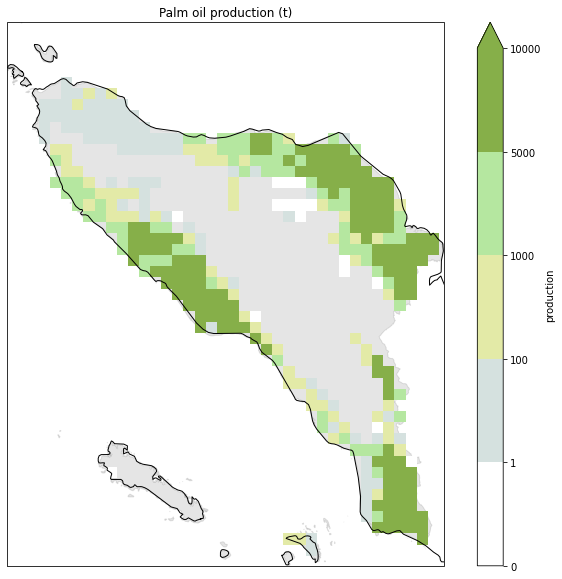

In [13]:
color_list = ["#ffffff", "#d5e1df", "#e3eaa7", "#b5e7a0", "#86af49"]
values = [0, 1, 100, 1000, 5000, 10000]
title = 'Palm oil production (t)'

da_plot(xds_idn['production'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Total production of Palm oil in Aceh**

In [14]:
tot_pro = xds_idn["production"].sum().data
print(f'Total production of Palm oil in Aceh: {tot_pro} tons')

Total production of Palm oil in Aceh: 2587794.5 tons


**Total harvest area of Palm oil in Aceh**

In [15]:
tot_ha = xds_idn["harvested_area"].sum().data
print(f'Total harvest area of Palm oil in Aceh: {tot_ha} hectares')

Total harvest area of Palm oil in Aceh: 228619.3125 hectares


### **Land "risk"**

Land risk (ha/t)  = (Harvested area (ha) / Production (t)) 

In [16]:
xds_idn = xds_idn.assign(land_risk = xds_idn["harvested_area"]/xds_idn["production"])

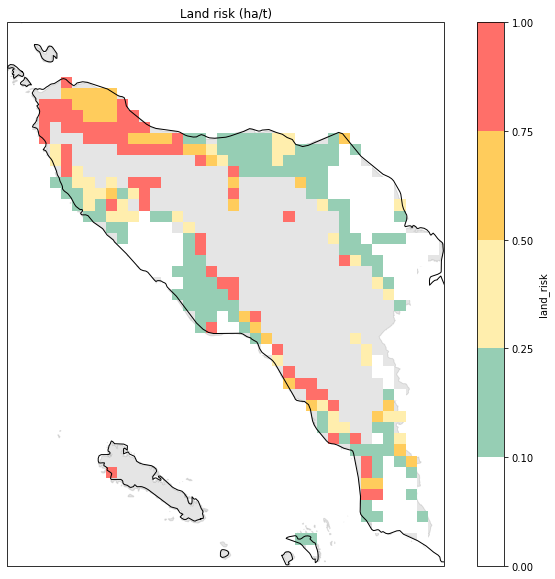

In [17]:
color_list = ["#ffffff", "#96ceb4", "#ffeead", "#ffcc5c", "#ff6f69"]
values = [0, 0.1, 0.25, 0.5, 0.75, 1]
title = 'Land risk (ha/t)'
da_plot(xds_idn['land_risk'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

### **Evenly distributed volume**

If the volume is distributed evenly across the entire area

Land impact (ha)  = (Harvested area (ha) / Production (t)) * Volume (t)

In [18]:
mean_risk = xds_idn['land_risk'].mean().data
print(f'Total land impact for palm oil in Aceh:: {mean_risk * volume} ha')

Total land impact for palm oil in Aceh:: 335.679292678833 ha


### **Probability purchase area**

The volume is distributed using the 'probabilistics purchase area' approach:

Probability purchase area (t)  = (Volume(t) / Total harvest area(ha)) * Harvest area(ha)

In [19]:
xds_idn = xds_idn.assign(probability_purchase_area = (volume/tot_ha)* xds_idn["harvested_area"])

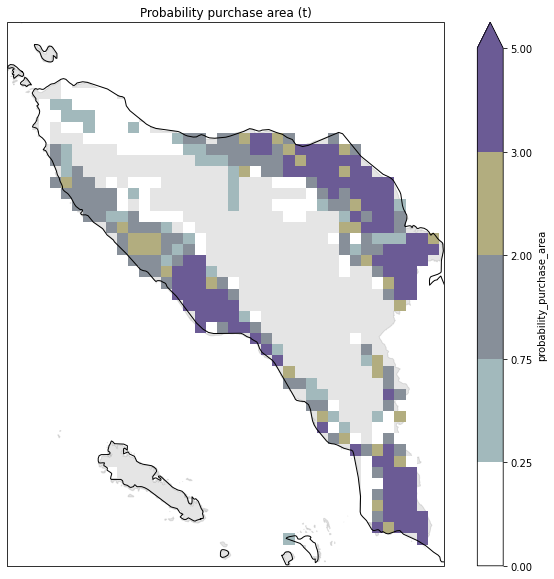

In [20]:
color_list = ["#ffffff", "#a2b9bc", "#878f99", "#b2ad7f", "#6b5b95"]
values = [0, 0.25, 0.75, 2, 3, 5]
title = 'Probability purchase area (t)'
da_plot(xds_idn['probability_purchase_area'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

Check that the volume distributed is equal to the volume injested by the user.

In [21]:
tot_volume = xds_idn["probability_purchase_area"].sum().data
print(f'Total distributed volume of cottom in India: {tot_volume} t')

Total distributed volume of cottom in India: 999.9999389648438 t


**Land impact**

Land impact (ha)  = (Harvested area (ha) / Production (t)) * (Harvested area (ha) / Total Harvested area (ha)) * Volume (t)

In [22]:
xds_idn = xds_idn.assign(land_impact = (xds_idn['land_risk'] * xds_idn['probability_purchase_area']))

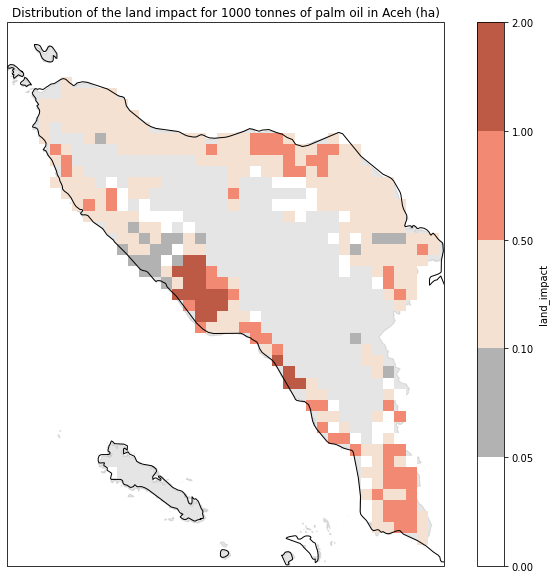

In [23]:
color_list = ["#ffffff", "#b2b2b2", "#f4e1d2", "#f18973", "#bc5a45"]
values = [0, 0.05, 0.1, 0.5, 1, 2]

title = 'Distribution of the land impact for 1000 tonnes of palm oil in Aceh (ha)'

da_plot(xds_idn['land_impact'],geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Total impact for for 1000 tonnes of palm oil in Aceh**

In [24]:
tot_impact = xds_idn['land_impact'].sum().data
print(f'Total land impact for for 1000 tonnes of palm oil in Aceh: {tot_impact} ha')

Total land impact for for 1000 tonnes of palm oil in Aceh: 132.16741943359375 ha


**Total impact of all produced palm oil in Aceh**

In [25]:
tot_impact_all = (((xds_idn["harvested_area"])/xds_idn["production"]) * (xds_idn["harvested_area"]/tot_ha) * tot_pro).sum().data
print(f'Total land impact for palm oil in Aceh: {tot_impact_all} ha')

Total land impact for palm oil in Aceh: 342022.125 ha


<a id='deforestation'></a>
# Deforestation loss due to land use change

Deforestation impact (ha)  = Deforestation area (unitless) * Land impact (ha)

<a id='loss'></a>
### **Tree cover loss**
#### Tree cover loss per year
**Read data**

In [26]:
xda = rxr.open_rasterio('../../datasets/raw/deforestation/Hansen_GFC-2020-v1.8_lossyear_10N_090E.tif').squeeze().drop("band")

# Convert to Dataset 
xds_loss = xr.Dataset({'tree_cover_loss_year': xda}, attrs=xda.attrs)
xds_loss = xds_loss.sel(x=slice(bounds[0]+2,bounds[2]), y=slice(bounds[3]-1,bounds[1]+1))
xds_loss

<xarray.Dataset>
Dimensions:               (x: 5105, y: 8276)
Coordinates:
  * x                     (x) float64 97.01 97.01 97.01 ... 98.29 98.29 98.29
  * y                     (y) float64 5.077 5.077 5.076 ... 3.009 3.008 3.008
    spatial_ref           int64 0
Data variables:
    tree_cover_loss_year  (y, x) uint8 ...
Attributes:
    LAYER_TYPE:    athematic
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     Layer_1

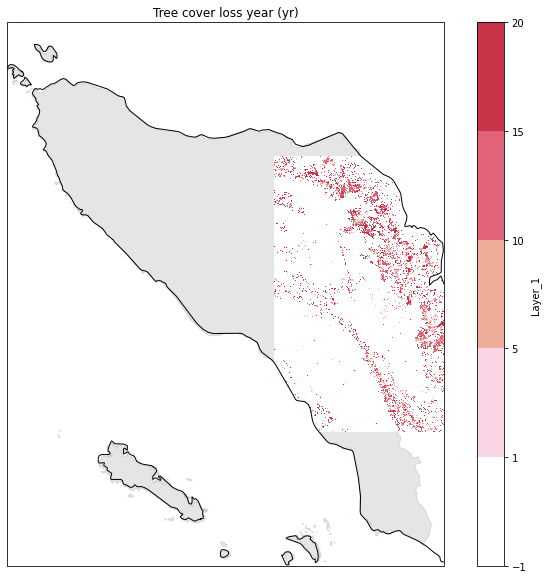

In [27]:
color_list = ["#ffffff", "#f9d5e5", "#eeac99", "#e06377", "#c83349"]
values = [-1, 1, 5, 10, 15, 20]
title = 'Tree cover loss year (yr)'

da_plot(xds_loss['tree_cover_loss_year'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Tree cover loss in 2020**

Create mask of tree cover loss in 2020

In [28]:
with rio.open("../../datasets/raw/deforestation/Hansen_GFC-2020-v1.8_lossyear_10N_090E.tif") as dataset:
    # read metadata
    ras_meta = dataset.profile
    # read first band
    data = dataset.read(1)

    # create mask for year 2020
    data = np.where(data > 19, data, 0)
    data = np.where(data < 20, data, 1)

with rio.open("../../datasets/raw/deforestation/Hansen_GFC-2020-v1.8_loss_2020_10N_090E.tif", 'w', **ras_meta) as dataset:
    dataset.write(data, indexes=1)


In [28]:
xda = rxr.open_rasterio('../../datasets/raw/deforestation/Hansen_GFC-2020-v1.8_loss_2020_10N_090E.tif').squeeze().drop("band")

# Convert to Dataset 
xds_loss = xr.Dataset({'tree_cover_loss_2020': xda}, attrs=xda.attrs)
xds_loss = xds_loss.sel(x=slice(bounds[0]+2,bounds[2]), y=slice(bounds[3]-1,bounds[1]+1))
xds_loss

<xarray.Dataset>
Dimensions:               (x: 5105, y: 8276)
Coordinates:
  * x                     (x) float64 97.01 97.01 97.01 ... 98.29 98.29 98.29
  * y                     (y) float64 5.077 5.077 5.076 ... 3.009 3.008 3.008
    spatial_ref           int64 0
Data variables:
    tree_cover_loss_2020  (y, x) uint8 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

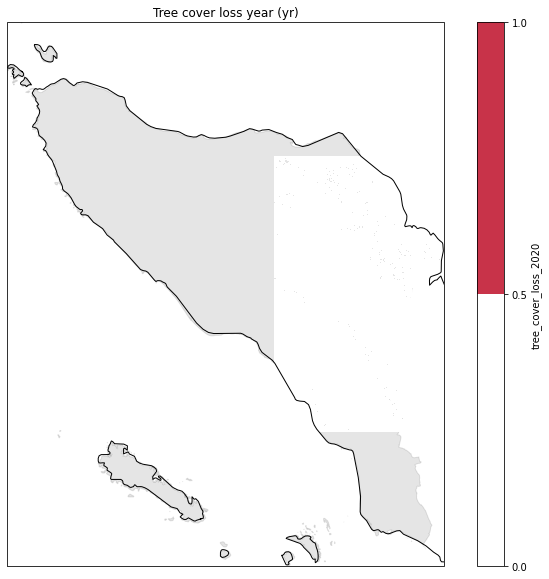

In [29]:
color_list = ["#ffffff", "#c83349"]
values = [0, 0.5, 1]
title = 'Tree cover loss year (yr)'

da_plot(xds_loss['tree_cover_loss_2020'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Upsample tree cover loss to match crop data**

Transform from `uint8` to `float64`

In [31]:
inputFile = '../../datasets/raw/deforestation/Hansen_GFC-2020-v1.8_loss_2020_10N_090E.tif'
outputFile = '../../datasets/raw/deforestation/Hansen_GFC-2020-v1.8_loss_2020_10N_090E_float.tif'
ds = gdal.Translate(outputFile, inputFile, outputType=gdal.gdalconst.GDT_Float64)
del ds

Upsample

In [31]:
# reference file
referenceFile = '../../datasets/raw/spam2010v2r0_global_prod/spam2010V2r0_global_P_OILP_A.tif'
# Specify input and output filenames
inputFile = '../../datasets/raw/deforestation/Hansen_GFC-2020-v1.8_loss_2020_10N_090E_float.tif'
outputFile = '../../datasets/raw/deforestation/Hansen_GFC-2020-v1.8_loss_2020_10N_090E_float_10x10.tif'

upsample_raster(referenceFile, inputFile, outputFile)

In [32]:
xda = rxr.open_rasterio(outputFile).squeeze().drop("band")

# Convert to Dataset 
xds_loss = xr.Dataset({'tree_cover_loss_2020': xda}, attrs=xda.attrs)
xds_loss

<xarray.Dataset>
Dimensions:               (x: 120, y: 120)
Coordinates:
  * x                     (x) float64 90.04 90.12 90.21 ... 99.79 99.87 99.96
  * y                     (y) float64 9.958 9.875 9.792 ... 0.2084 0.125 0.04171
    spatial_ref           int64 0
Data variables:
    tree_cover_loss_2020  (y, x) float32 ...
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

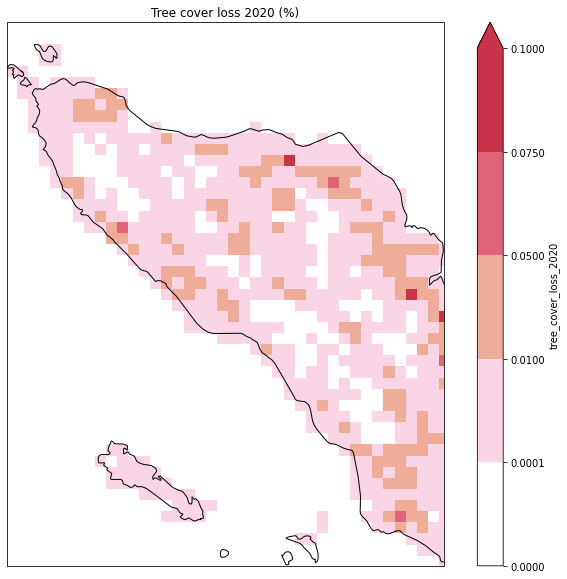

In [33]:
color_list = ["#ffffff", "#f9d5e5", "#eeac99", "#e06377", "#c83349"]
values = [0, 0.0001, 0.01, 0.05, 0.075, 0.1]
title = 'Tree cover loss 2020 (%)'

da_plot(xds_loss['tree_cover_loss_2020'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Clip datasets with Indonesia**

In [34]:
xds_loss_idn = xds_loss.rio.clip(geom.geometry, geom.crs, drop=False, invert=False)
xds_loss_idn = xds_loss_idn.sel(x=slice(bounds[0],bounds[2]), y=slice(bounds[3],bounds[1]))
xds_loss_idn

<xarray.Dataset>
Dimensions:               (y: 49, x: 39)
Coordinates:
  * y                     (y) float64 6.042 5.958 5.875 ... 2.208 2.125 2.042
  * x                     (x) float64 95.04 95.12 95.21 ... 98.04 98.12 98.21
    spatial_ref           int64 0
Data variables:
    tree_cover_loss_2020  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

**Merge datasets**

In [35]:
# Assign MAPSPAM coords
xds_loss_idn = xds_loss_idn.assign_coords(x=xds_idn.x.values)
xds_loss_idn = xds_loss_idn.assign_coords(y=xds_idn.y.values)

xds_idn['tree_cover_loss_2020'] = xds_loss_idn['tree_cover_loss_2020']
xds_idn

<xarray.Dataset>
Dimensions:                    (y: 49, x: 39)
Coordinates:
  * y                          (y) float64 6.042 5.959 5.875 ... 2.125 2.042
  * x                          (x) float64 95.04 95.12 95.21 ... 98.12 98.21
    spatial_ref                int64 0
Data variables:
    harvested_area             (y, x) float32 nan nan nan nan ... nan nan nan
    production                 (y, x) float32 nan nan nan nan ... nan nan nan
    land_risk                  (y, x) float32 nan nan nan nan ... nan nan nan
    probability_purchase_area  (y, x) float32 nan nan nan nan ... nan nan nan
    land_impact                (y, x) float32 nan nan nan nan ... nan nan nan
    tree_cover_loss_2020       (y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

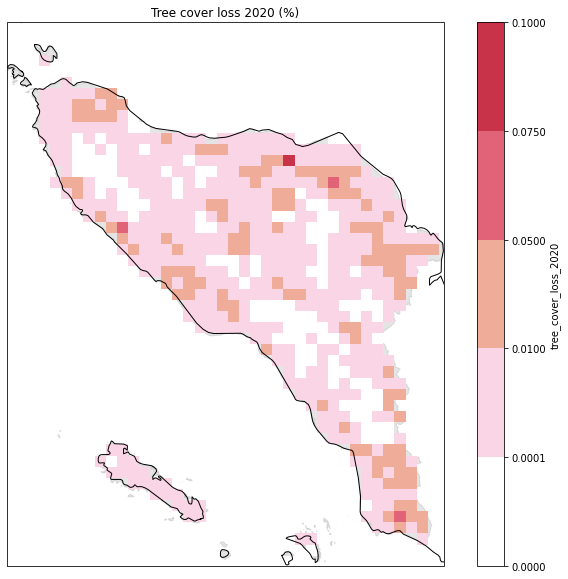

In [36]:
color_list = ["#ffffff", "#f9d5e5", "#eeac99", "#e06377", "#c83349"]
values = [0, 0.0001, 0.01, 0.05, 0.075, 0.1]
title = 'Tree cover loss 2020 (%)'

da_plot(xds_idn['tree_cover_loss_2020'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

### **Deforestation impact**
Deforestation impact (ha)  = Deforestation area (unitless) * Land impact (ha)

In [37]:
xds_idn = xds_idn.assign(deforestation_impact = xds_idn["tree_cover_loss_2020"] * xds_idn["land_impact"])

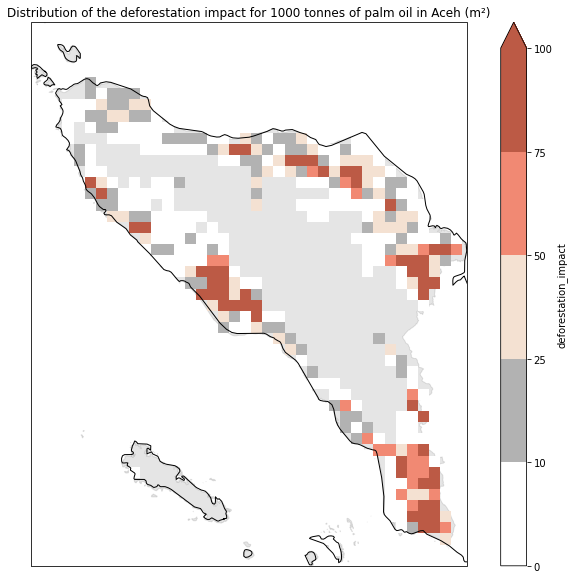

In [38]:
color_list = ["#ffffff", "#b2b2b2", "#f4e1d2", "#f18973", "#bc5a45"]
values = [0, 10, 25, 50, 75, 100]

title = 'Distribution of the deforestation impact for 1000 tonnes of palm oil in Aceh (m²)'

da_plot(xds_idn['deforestation_impact']*10000,geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Total deforestation impact for for 1000 tonnes of palm oil in Aceh**

In [39]:
tot_def_impact = xds_idn['deforestation_impact'].sum().data
print(f'Total deforestation impact for 1000 tonnes of palm oil in Aceh 2020: {tot_def_impact} ha')

Total deforestation impact for 1000 tonnes of palm oil in Aceh 2020: 1.282185435295105 ha


**Total deforestation impact of all produced palm oil in Aceh**

In [40]:
tot_def_impact_all = (xds_idn['tree_cover_loss_2020'] * ((xds_idn["harvested_area"])/xds_idn["production"]) * (xds_idn["harvested_area"]/tot_ha) * tot_pro).sum().data
print(f'Total deforestation impact for palm oil in Aceh 2020: {tot_def_impact_all} ha')

Total deforestation impact for palm oil in Aceh 2020: 3318.032470703125 ha


**Total deforestation in Aceh**

In [41]:
pix_ha = 1000
tot_def_aceh = (xds_idn['tree_cover_loss_2020']*pix_ha).sum().data
print(f'Total deforestation in Aceh 2020: {tot_def_aceh} ha')

Total deforestation in Aceh 2020: 3864.02001953125 ha


<a id='carbon'></a>
# Carbon emissions due to land use change

Carbon impact (tCO₂e) = Net forest GHG flux (tCO₂e ha⁻¹)Deforestation impact (ha)

<a id='flux'></a>
### **Forest greenhouse gas net flux**
#### Forest greenhouse gas net flux (2001-2020)
**Read data**

The [Net forest GHG flux](https://data.globalforestwatch.org/datasets/66eafb4f16f9478c828c3225d26b4989) that we are using to compute the carbon impact is the cumulative net flux during the model period (2001-2020) and must be divided by 19 to obtain average annual net flux.

In [68]:
n_years = 19

In [42]:
xda = rxr.open_rasterio('../../datasets/raw/carbon/Forest_GHG_net_flux_Geotiff/10N_090E.tif').squeeze().drop("band")

# Convert to Dataset 
xds_flux = xr.Dataset({'forest_GHG_net_flux': xda}, attrs=xda.attrs)
xds_flux = xds_flux.sel(x=slice(bounds[0]+2,bounds[2]), y=slice(bounds[3]-1,bounds[1]+1))
xds_flux

<xarray.Dataset>
Dimensions:              (x: 5105, y: 8276)
Coordinates:
  * x                    (x) float64 97.01 97.01 97.01 ... 98.29 98.29 98.29
  * y                    (y) float64 5.077 5.077 5.076 ... 3.009 3.008 3.008
    spatial_ref          int64 0
Data variables:
    forest_GHG_net_flux  (y, x) float32 ...
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0

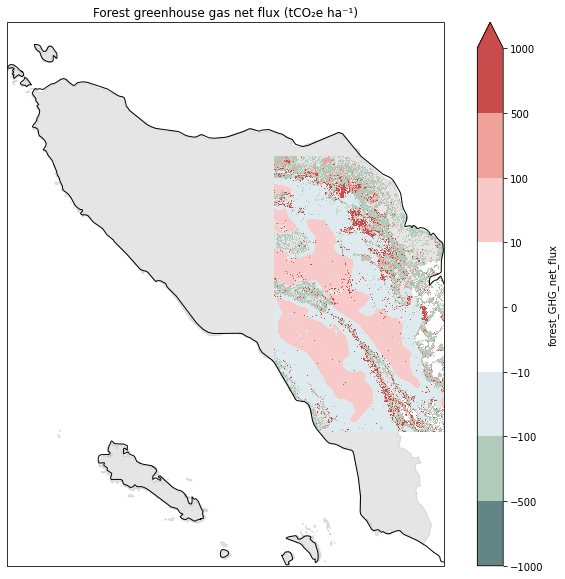

In [43]:
color_list = ["#618685", "#b1cbbb", "#deeaee", "#ffffff", "#ffffff", "#f7cac9", "#eea29a", "#c94c4c"]
values = [-1000, -500, -100, -10, 0, 10, 100, 500, 1000]
title = 'Forest greenhouse gas net flux (tCO₂e ha⁻¹)'

da_plot(xds_flux['forest_GHG_net_flux'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Upsample tree cover loss to match crop data**

In [44]:
# reference file
referenceFile = '../../datasets/raw/spam2010v2r0_global_prod/spam2010V2r0_global_P_OILP_A.tif'
# Specify input and output filenames
inputFile = '../../datasets/raw/carbon/Forest_GHG_net_flux_Geotiff/10N_090E.tif'
outputFile = '../../datasets/raw/carbon/Forest_GHG_net_flux_Geotiff/10N_090E_10x10.tif'

upsample_raster(referenceFile, inputFile, outputFile)

In [45]:
xda = rxr.open_rasterio(outputFile).squeeze().drop("band")

# Convert to Dataset 
xds_flux = xr.Dataset({'forest_GHG_net_flux': xda}, attrs=xda.attrs)
xds_flux

<xarray.Dataset>
Dimensions:              (x: 120, y: 120)
Coordinates:
  * x                    (x) float64 90.04 90.12 90.21 ... 99.79 99.87 99.96
  * y                    (y) float64 9.958 9.875 9.792 ... 0.2084 0.125 0.04171
    spatial_ref          int64 0
Data variables:
    forest_GHG_net_flux  (y, x) float32 ...
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0

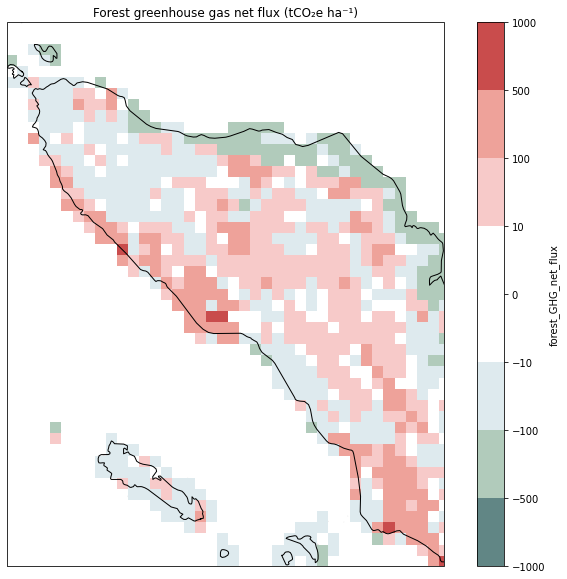

In [67]:
color_list = ["#618685", "#b1cbbb", "#deeaee", "#ffffff", "#ffffff", "#f7cac9", "#eea29a", "#c94c4c"]
values = [-1000, -500, -100, -10, 0, 10, 100, 500, 1000]
title = 'Forest greenhouse gas net flux (tCO₂e ha⁻¹)'

da_plot(xds_flux['forest_GHG_net_flux'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Clip datasets with Indonesia**

In [47]:
xds_flux_idn = xds_flux.rio.clip(geom.geometry, geom.crs, drop=False, invert=False)
xds_flux_idn = xds_flux_idn.sel(x=slice(bounds[0],bounds[2]), y=slice(bounds[3],bounds[1]))
xds_flux_idn

<xarray.Dataset>
Dimensions:              (y: 49, x: 39)
Coordinates:
  * y                    (y) float64 6.042 5.958 5.875 ... 2.208 2.125 2.042
  * x                    (x) float64 95.04 95.12 95.21 ... 98.04 98.12 98.21
    spatial_ref          int64 0
Data variables:
    forest_GHG_net_flux  (y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0

**Merge datasets**

In [48]:
# Assign MAPSPAM coords
xds_flux_idn = xds_flux_idn.assign_coords(x=xds_idn.x.values)
xds_flux_idn = xds_flux_idn.assign_coords(y=xds_idn.y.values)

xds_idn['forest_GHG_net_flux'] = xds_flux_idn['forest_GHG_net_flux']
xds_idn

<xarray.Dataset>
Dimensions:                    (y: 49, x: 39)
Coordinates:
  * y                          (y) float64 6.042 5.959 5.875 ... 2.125 2.042
  * x                          (x) float64 95.04 95.12 95.21 ... 98.12 98.21
    spatial_ref                int64 0
Data variables:
    harvested_area             (y, x) float32 nan nan nan nan ... nan nan nan
    production                 (y, x) float32 nan nan nan nan ... nan nan nan
    land_risk                  (y, x) float32 nan nan nan nan ... nan nan nan
    probability_purchase_area  (y, x) float32 nan nan nan nan ... nan nan nan
    land_impact                (y, x) float32 nan nan nan nan ... nan nan nan
    tree_cover_loss_2020       (y, x) float32 nan nan nan nan ... nan nan nan
    deforestation_impact       (y, x) float32 nan nan nan nan ... nan nan nan
    forest_GHG_net_flux        (y, x) float32 nan nan nan nan ... nan nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

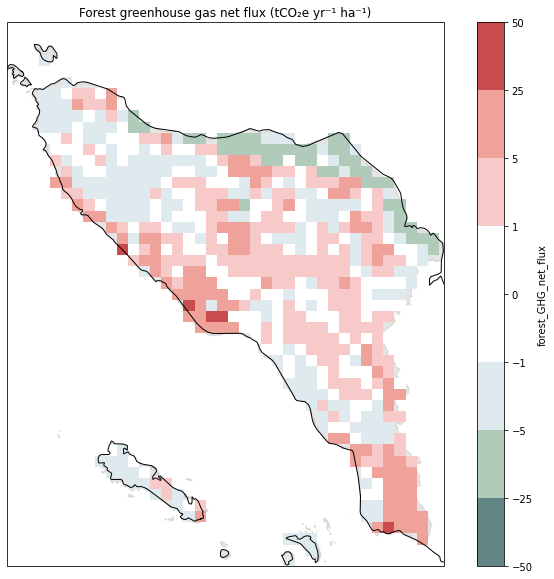

In [72]:
color_list = ["#618685", "#b1cbbb", "#deeaee", "#ffffff", "#ffffff", "#f7cac9", "#eea29a", "#c94c4c"]
values = [-50, -25, -5, -1, 0, 1, 5, 25, 50]
title = 'Forest greenhouse gas net flux (tCO₂e yr⁻¹ ha⁻¹)'

da_plot(xds_idn['forest_GHG_net_flux']/n_years, geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

### **Carbon impact**
Carbon impact (tCO₂e) = Net forest GHG flux (tCO₂e ha⁻¹) * Deforestation impact (ha)

In [74]:
xds_idn = xds_idn.assign(carbon_impact = (xds_idn["forest_GHG_net_flux"]/n_years) * xds_idn["deforestation_impact"])

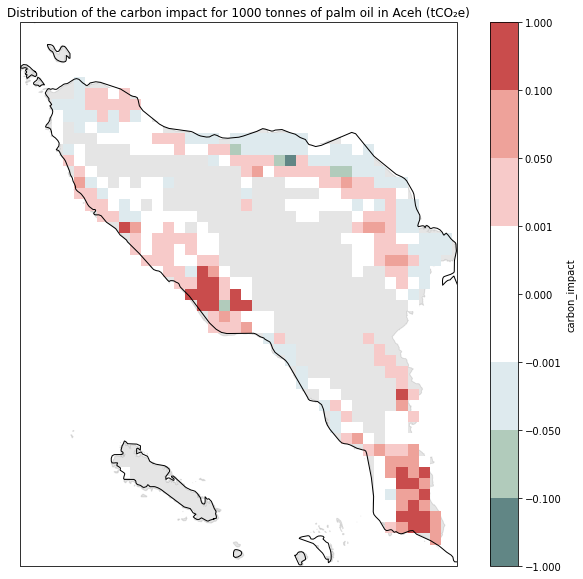

In [76]:
color_list = ["#618685", "#b1cbbb", "#deeaee", "#ffffff", "#ffffff", "#f7cac9", "#eea29a", "#c94c4c"]
values = [-1, -0.1, -0.05, -0.001, 0, 0.001, 0.05, 0.1, 1]

title = 'Distribution of the carbon impact for 1000 tonnes of palm oil in Aceh (tCO₂e)'

da_plot(xds_idn['carbon_impact'],geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Total carbon impact for for 1000 tonnes of palm oil in Aceh**

In [77]:
tot_car_impact = xds_idn['carbon_impact'].sum().data
print(f'Total carbon impact for 1000 tonnes of palm oil in Aceh: {tot_car_impact} tCO₂e')

Total carbon impact for 1000 tonnes of palm oil in Aceh: 6.414007663726807 tCO₂e


**Total carbon impact of all produced palm oil in Aceh**

In [79]:
tot_car_impact_all = (xds_idn["forest_GHG_net_flux"]/n_years * xds_idn['tree_cover_loss_2020'] * \
                     ((xds_idn["harvested_area"])/xds_idn["production"]) * (xds_idn["harvested_area"]/tot_ha) * tot_pro).sum().data
print(f'Total carbon impact for palm oil in Aceh 2020: {tot_car_impact_all} tCO₂e')

Total carbon impact for palm oil in Aceh 2020: 16598.1328125 tCO₂e


**Total Net forest GHG flux in Aceh**

In [81]:
pix_ha = 1000
tot_car_aceh = ((xds_idn['forest_GHG_net_flux']/n_years)*pix_ha).sum().data
print(f'Total Net forest GHG flux in Aceh 2001-2020: {tot_car_aceh} tCO₂e')

Total Net forest GHG flux in Aceh 2001-2020: 882705.75 tCO₂e


<a id='biodiversity'></a>
# Biodiversity loss due to land use change

Biodiversity impact (PDF yr⁻¹) = PSL(PDF m⁻² yr⁻¹) * 10⁴(m² ha⁻¹) * Deforestation impact (ha)

 <a id='species'></a>
### **Regional Potential Species Loss**
**Read data**

In [55]:
xda = rxr.open_rasterio('../../datasets/raw/biodiversity/taxa_aggregated_characterization_factors_4326.tif').squeeze().drop("band")

# Convert to Dataset 
xds_bio = xr.Dataset({'taxa_aggregated_characterization_factors': xda.where(xda > 0)}, attrs=xda.attrs)
xds_bio

<xarray.Dataset>
Dimensions:                                   (x: 4320, y: 2160)
Coordinates:
  * x                                         (x) float64 -180.0 ... 180.0
  * y                                         (y) float64 89.96 89.88 ... -89.96
    spatial_ref                               int64 0
Data variables:
    taxa_aggregated_characterization_factors  (y, x) float32 nan nan ... nan nan
Attributes:
    STATISTICS_MAXIMUM:        4.2704600966559e-10
    STATISTICS_MEAN:           2.9376220100729e-12
    STATISTICS_MINIMUM:        2.8999999152285e-14
    STATISTICS_STDDEV:         6.255799719857e-12
    STATISTICS_VALID_PERCENT:  19.98
    _FillValue:                0.0
    scale_factor:              1.0
    add_offset:                0.0

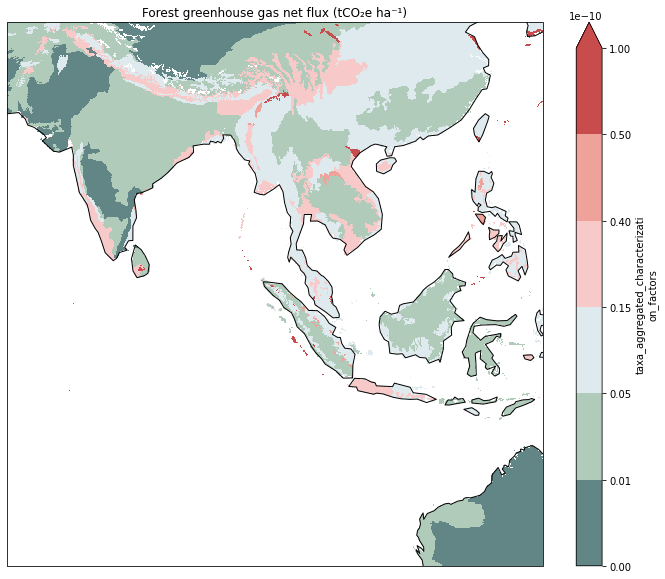

In [56]:
color_list = ["#618685", "#b1cbbb", "#deeaee", "#f7cac9", "#eea29a", "#c94c4c"]
values = list(np.array([0, 0.01, 0.05, 0.15, 0.4, 0.5, 1])*1e-10)
title = 'Forest greenhouse gas net flux (tCO₂e ha⁻¹)'

da_plot(xds_bio['taxa_aggregated_characterization_factors'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0]-30,bounds[2]+30), ylim=(bounds[1]-30,bounds[3]+30))

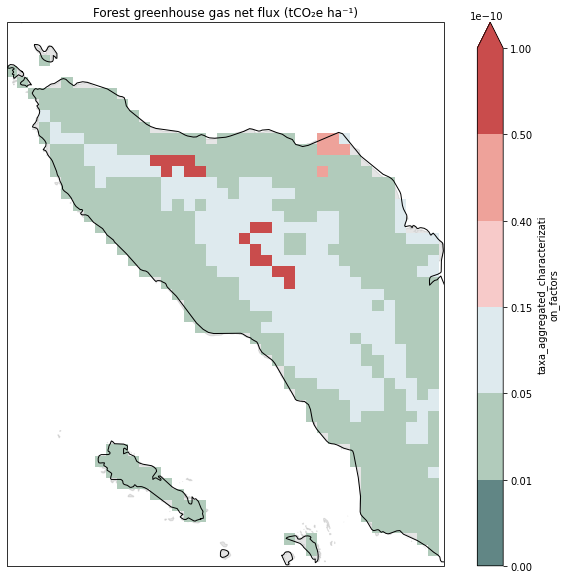

In [57]:
xds_bio = xds_bio.sel(x=slice(bounds[0],bounds[2]), y=slice(bounds[3],bounds[1]))

color_list = ["#618685", "#b1cbbb", "#deeaee", "#f7cac9", "#eea29a", "#c94c4c"]
values = list(np.array([0, 0.01, 0.05, 0.15, 0.4, 0.5, 1])*1e-10)
title = 'Forest greenhouse gas net flux (tCO₂e ha⁻¹)'

da_plot(xds_bio['taxa_aggregated_characterization_factors'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Clip datasets with Aceh**

In [58]:
xds_bio_idn = xds_bio.rio.clip(geom.geometry, geom.crs, drop=False, invert=False)
xds_bio_idn = xds_bio_idn.sel(x=slice(bounds[0],bounds[2]), y=slice(bounds[3],bounds[1]))
xds_bio_idn['taxa_aggregated_characterization_factors'] = xds_bio_idn['taxa_aggregated_characterization_factors'].where(xds_bio_idn['taxa_aggregated_characterization_factors'] > 0)
xds_bio_idn

<xarray.Dataset>
Dimensions:                                   (y: 49, x: 39)
Coordinates:
  * y                                         (y) float64 6.042 5.958 ... 2.042
  * x                                         (x) float64 95.04 95.12 ... 98.21
    spatial_ref                               int64 0
Data variables:
    taxa_aggregated_characterization_factors  (y, x) float32 nan nan ... nan nan
Attributes:
    STATISTICS_MAXIMUM:        4.2704600966559e-10
    STATISTICS_MEAN:           2.9376220100729e-12
    STATISTICS_MINIMUM:        2.8999999152285e-14
    STATISTICS_STDDEV:         6.255799719857e-12
    STATISTICS_VALID_PERCENT:  19.98
    _FillValue:                0.0
    scale_factor:              1.0
    add_offset:                0.0

**Merge datasets**

In [59]:
# Assign MAPSPAM coords
xds_bio_idn = xds_bio_idn.assign_coords(x=xds_idn.x.values)
xds_bio_idn = xds_bio_idn.assign_coords(y=xds_idn.y.values)

xds_idn['taxa_aggregated_characterization_factors'] = xds_bio_idn['taxa_aggregated_characterization_factors']
xds_idn

<xarray.Dataset>
Dimensions:                                   (y: 49, x: 39)
Coordinates:
  * y                                         (y) float64 6.042 5.959 ... 2.042
  * x                                         (x) float64 95.04 95.12 ... 98.21
    spatial_ref                               int64 0
Data variables:
    harvested_area                            (y, x) float32 nan nan ... nan nan
    production                                (y, x) float32 nan nan ... nan nan
    land_risk                                 (y, x) float32 nan nan ... nan nan
    probability_purchase_area                 (y, x) float32 nan nan ... nan nan
    land_impact                               (y, x) float32 nan nan ... nan nan
    tree_cover_loss_2020                      (y, x) float32 nan nan ... nan nan
    deforestation_impact                      (y, x) float32 nan nan ... nan nan
    forest_GHG_net_flux                       (y, x) float32 nan nan ... nan nan
    carbon_impact                             (y, x) float32 nan nan ... nan nan
    taxa_aggregated_characterization_factors  (y, x) float32 nan nan ... nan nan
Attributes:
    _FillValue:    -1.0
    scale_factor:  1.0
    add_offset:    0.0

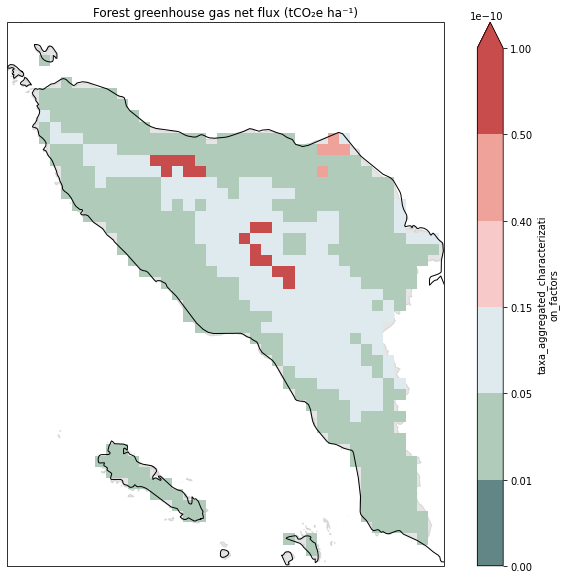

In [60]:
color_list = ["#618685", "#b1cbbb", "#deeaee", "#f7cac9", "#eea29a", "#c94c4c"]
values = list(np.array([0, 0.01, 0.05, 0.15, 0.4, 0.5, 1])*1e-10)
title = 'Forest greenhouse gas net flux (tCO₂e ha⁻¹)'

da_plot(xds_idn['taxa_aggregated_characterization_factors'], geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

### **Biodiversity  impact**
Biodiversity impact (PDF yr⁻¹) = PSL(PDF m⁻² yr⁻¹) * 10⁴(m² ha⁻¹) * Deforestation impact (ha)

In [61]:
xds_idn = xds_idn.assign(biodiversity_impact = xds_idn["taxa_aggregated_characterization_factors"] * 10000 * xds_idn["deforestation_impact"])

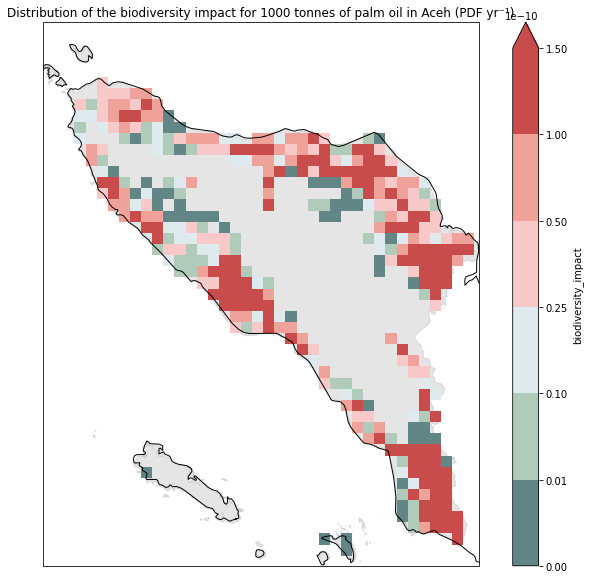

In [63]:
color_list = ["#618685", "#b1cbbb", "#deeaee", "#f7cac9", "#eea29a", "#c94c4c"]
values = list(np.array([0, 0.01, 0.1, 0.25, 0.5, 1, 1.5])*1e-10)

title = 'Distribution of the biodiversity impact for 1000 tonnes of palm oil in Aceh (PDF yr⁻¹)'

da_plot(xds_idn['biodiversity_impact'],geom, color_list, values, title, x='x', y='y', xlim=(bounds[0],bounds[2]), ylim=(bounds[1],bounds[3]))

**Total biodiversity impact for for 1000 tonnes of palm oil in Aceh**

In [65]:
tot_bio_impact = xds_idn['biodiversity_impact'].sum().data
print(f'Total biodiversity impact for 1000 tonnes of palm oil in Aceh: {tot_bio_impact} PDF yr⁻¹)')

Total biodiversity impact for 1000 tonnes of palm oil in Aceh: 5.202602437748283e-08 PDF yr⁻¹)


**Total biodiversity impact of all produced palm oil in Aceh**

In [66]:
tot_bio_impact_all = (xds_idn["taxa_aggregated_characterization_factors"] * xds_idn['tree_cover_loss_2020'] * \
                     ((xds_idn["harvested_area"])/xds_idn["production"]) * (xds_idn["harvested_area"]/tot_ha) * tot_pro).sum().data
print(f'Total biodiversity impact for palm oil in Aceh: {tot_bio_impact_all} PDF yr⁻¹')

Total biodiversity impact for palm oil in Aceh: 1.3463266945734631e-08 PDF yr⁻¹
